# Contents

 - Introduction
 - Simplest example of algorithm vs inference
 - Bias-Variance Tradeof with Loess

# Introduction

[Computer Age Statistical Inference](https://web.stanford.edu/~hastie/CASI/), a recent publication by Efron and Hastie, has recieved rave reviews across the statistical world for the clarity of its writing and its historical view.  Having completed my [MA in Information and Data Science](https://www.ischool.berkeley.edu/programs/mids) from UC Berkeley, this blog is an attempt to reinforce my theoretical knowledge of statistics, by spending time to deeply understand the concepts discussed in CASI

Chapter one starts off with a powerful framework, distinguishing between _algorithmic_ and _inferential_ aspects to statistics.  In CASI's words, algorithms say what the statistician does, inference states why he or she does it.  

Personally, I would modify that definition somewhat: the algorithm is what the statistician calculates, while inference defines what the calculation means.  

# The simplest example possible

CASI starts off with the simplest example possible, taking an average, which is the _algorithm_: 

$$\bar{x} = \sum_{i=1}^n \frac{x_{i}}{n}$$

and then gives an example of inference, which asks: "How accurate is that average?"  This is typically given as a standard error: 

$$ \hat{se} = \big[\sum_{i=1}^n \frac{(x_{i} - \bar{x})^2}{(n(n-1))} \Big]^\frac{1}{2}$$

Lets see a demonstration in python

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import summary_table
import plotly
import plotly.plotly as py
import plotly.graph_objs as go


## Initial Settings
np.random.seed(1234)
plotly.offline.init_notebook_mode(connected=True)

n = 10000
X = np.random.randn(n)

## Sample from the True distribution
sample_size = 1000
x_sample = np.random.choice(X, replace=True, size=1000)

## Compare  means
true_mean = X.mean()
sample_mean = x_sample.mean()

## Calculate Standard Error
var_x = (x_sample-sample_mean)**2
dof = sample_size*(sample_size-1)
se_hat = np.sum((var_x/dof))**(1/2)

print('True mean = {}, Sample mean = {}, Sample mean standard error = {}'.format(true_mean, sample_mean, se_hat))

C:\Users\jlandesman\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


True mean = 0.01612646004719804, Sample mean = 0.049097869530912525, Sample mean standard error = 0.03123906359002164


This says that if we were to repeat this experiment (drawing 1000 samples from a standard normal distribution) an infinite amount of times, 95% of the samples would have a mean between $\bar{x} \pm 2*\hat{se}$.  Lets test just to make sure:

In [3]:
num_samples = 10000 ## 10,000 samples:
means = []

## Repeatedly draw 1000 samples from our true distribution and calculate the mean
for i in range(num_samples):
    x_sample = np.random.choice(X, replace=True, size=1000)
    means.append(x_sample.mean())
means = np.array(means)

#Compare those means to the true mean and standard error
means_in_range = means[(means >= (true_mean - 2 * se_hat)) & (means <= (true_mean + 2 * se_hat))]

# Percent of means in range (should be 95%)
len(means_in_range)/len(means)

0.9543

This is a remarkable result!  We calculated our confidence in our data from our random draw alone, and it proved to be accurate.

# Bias-Variance Tradeoff and Modern Computation

CASI then introduces the bias-variance tradeoff (without saying as much) and new calculation options available with contemporary computing.  In particular, they run a simple regression (replicated below) on a dataset that is unevenly distributed, and compare it to a "LOESS" regression, which fits a polynomial line on rolling subsets of the data, dramatically increasing the computational resources necessary. 

Even more dramatically, in order to estimate how accurate the lowess calculation is, CASI conducts a **boostrap** confidence interval.  

A boostraped confidence interval (which CASI will delve into in future chapters) is calculated by randomly sampling the data _with replacement_ (such that in any given sample, a point may appear multiple times or not at all) and running the same rolling calculation for each sample.  This type of result is clearly impossible to achieve without modern computing power. 

Here is the base plot from CASI:

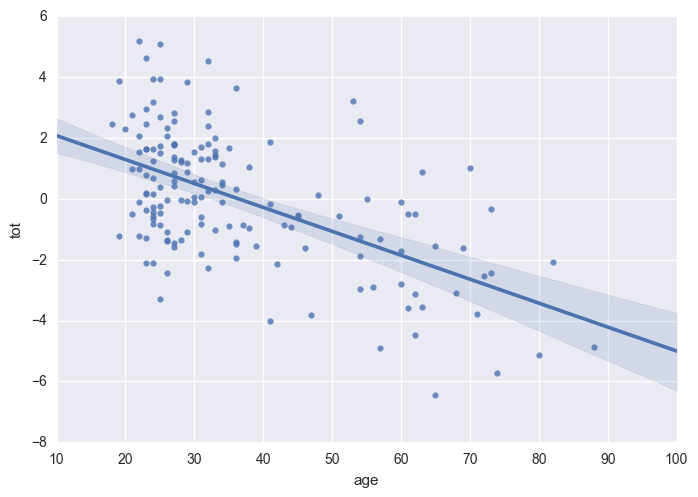

In [4]:
lowess = sm.nonparametric.lowess

df = pd.read_table('https://web.stanford.edu/~hastie/CASI_files/DATA/kidney.txt', sep=" ")
sns.regplot('age', 'tot', data=df)

Lets run the regression in statsmodels and save the necessary confidence intervals for comparison with lowess methods

In [4]:
## Run regression
model = smf.ols('tot ~ age', data=df)
regression_results = model.fit()
print(regression_results.summary().tables[1])

## Confidence intervals for individual points are hiding in statsmodels summary table - 
## see https://stackoverflow.com/questions/17559408/confidence-and-prediction-intervals-with-statsmodels/17560456
## Extract CI's by point
st, data, ss2 = summary_table(regression_results, alpha=0.05)
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8600      0.360      7.954      0.000       2.150       3.570
age           -0.0786      0.009     -8.678      0.000      -0.096      -0.061


And here is the lowess fit

In [5]:
## Run Lowess
y_lowess = lowess(df['tot'], df['age'], frac=0.33)[:,1]

#Plot Lowess
actual_data = go.Scatter(x = df['age'], y=df['tot'], mode='markers', name='Data')
fitted_data = go.Scatter(x = df['age'], y=y_lowess, mode='lines', name='Lowess')
layout = go.Layout(title='Lowess fit')

data = [actual_data, fitted_data]
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)

To calculate the confidence bands, resample randomly from X and Y and fit multiple lines

In [6]:
lowess_samples = []
num_samples = 1000

## Resample the dataframe with replacement and run lowess each time
for sample in range(num_samples):
    sampled_df = df.sample(n=df.shape[0], replace=True)
    y_lowess = lowess(sampled_df['tot'], sampled_df['age'], frac=0.33)[:,1]
    lowess_samples.append(y_lowess)

## Get average and StDev across all 1,000 samples
lowess_samples = pd.DataFrame(np.asarray(lowess_samples).T)
lowess_mean = lowess_samples.mean(axis=1)
lowess_stdev = lowess_samples.std(axis=1)

In [7]:
## Formulate data for comparison
ci_comparison = pd.DataFrame({'age': df['age'], 
                              'regression_mean': regression_results.fittedvalues,
                              'regression_confint_high': predict_mean_ci_upp,
                              'regression_confint_low': predict_mean_ci_low,
                              'lowess_mean': lowess_mean, 
                              'lowess_confint_high': lowess_mean + 2* lowess_stdev,
                              'lowess_confint_low': lowess_mean - 2*lowess_stdev})

## Take the mean at several ages
plot_data = ci_comparison[ci_comparison['age'].isin([20,25, 30,35])].groupby('age').mean().reset_index()


## Plotting
regression = go.Bar(
                x = plot_data['age'],
                y = plot_data['regression_mean'],
                error_y = dict(type = 'data',
                               symmetric=True, 
                               array=np.absolute(plot_data['regression_confint_high'] - plot_data['regression_mean'])),
                name='Linear Regression') 

lowess = go.Bar(
            x = plot_data['age'],
            y = plot_data['lowess_mean'],
            error_y = dict(type= 'data',
                           symmetric = True,
                           array = np.absolute(plot_data['lowess_confint_high']-plot_data['lowess_mean'])),
            name = 'Lowess'
            )

layout = go.Layout(title= 'Regression vs Lowess: Bias/Variance Tradeoff')

data = [regression, lowess]
fig = go.Figure(data=data, layout=layout)

plotly.offline.iplot(fig)